# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/Users/jonathangerber/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
df = pd.merge(df_offers, df_transactions)
df_pivot = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n').fillna(0).reset_index()

In [7]:
df_pivot.head()

offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

### Clustering and choosing the best k

In general, high SS means the centroids don't match the points, low SS means the centroids match the points. However, overfitting can still be problem (hence the elbow method).
Below is a test of differnt $k$s using the elbow method. The steps appear to level out at k=5 (although I wonder if the second derivative could be fit to the line in order to automate this choice).
As seen in the distribution plot, we still get more than 10 points per cluster. 
However, as we will see below, this dataset does not divide clearly into clusters. The less-pronounced elbow we have is consistent with this poor discrimination between clusters.

In [24]:
x_cols = np.matrix(df_pivot.drop(columns='customer_name'))

In [26]:
from sklearn.cluster import KMeans

# Set up a looping function to examine different cluster numbers.
ks = range(2,11)
ss = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(x_cols)
    ss.append(kmeans.inertia_)

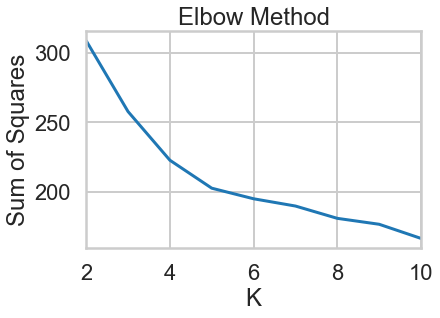

In [27]:
_ = plt.plot(ks, ss)
_ = plt.xlim([2,10])
_ = plt.xlabel('K')
_ = plt.ylabel('Sum of Squares')
_ = plt.title('Elbow Method')


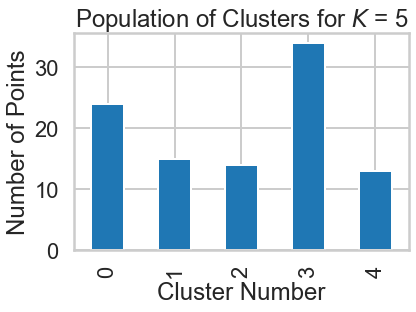

In [28]:
# your turn

# Refit the best clustering, which I put at k = 5. A basic 5 cluster predictor
cluster = KMeans(n_clusters=5)
df_pivot['cluster'] = cluster.fit_predict(x_cols)

cluster_sizes = pd.Series(df_pivot['cluster']).value_counts().sort_index()

_ = cluster_sizes.plot(kind='bar')
_ = plt.ylabel('Number of Points')
_ = plt.xlabel('Cluster Number')
_ = plt.title('Population of Clusters for $K$ = 5')

# 34 24 15 14 13

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

As found below in the plots, clusters start falling below the criterion as soon as k > 2. Some groups stay well defined as k goes up, but others fall below. This is consistent with the lack of clear clustering in the dataset.

Plotting the average silhouette score suggests k should be 3 or 4.

For n_clusters = 2 The average silhouette_score is : 0.3654561707288933


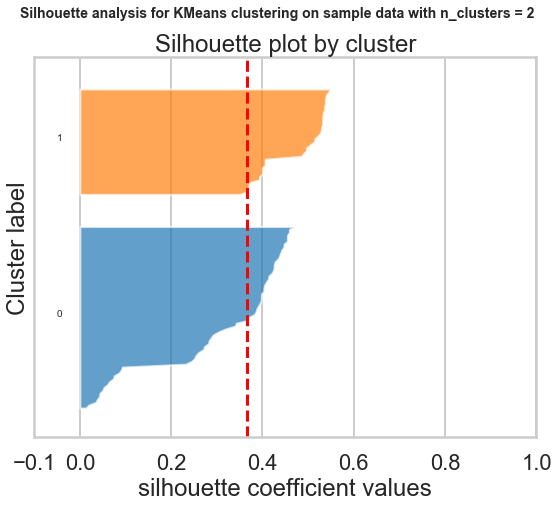

For n_clusters = 3 The average silhouette_score is : 0.2838437366307224


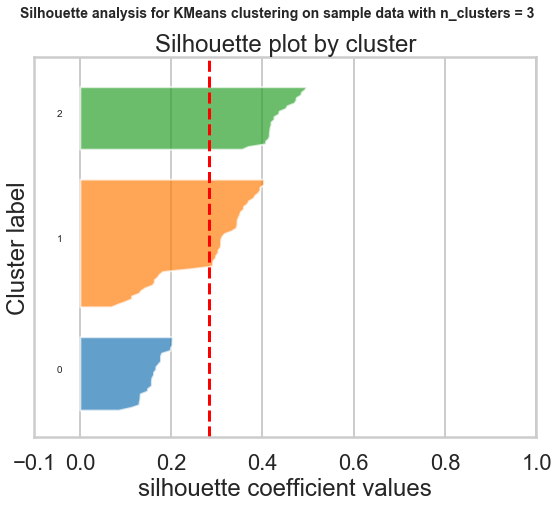

For n_clusters = 4 The average silhouette_score is : 0.26197849075526974


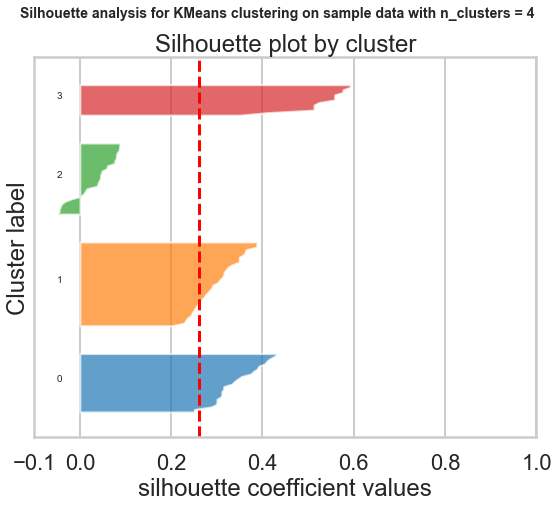

For n_clusters = 5 The average silhouette_score is : 0.2637005347617857


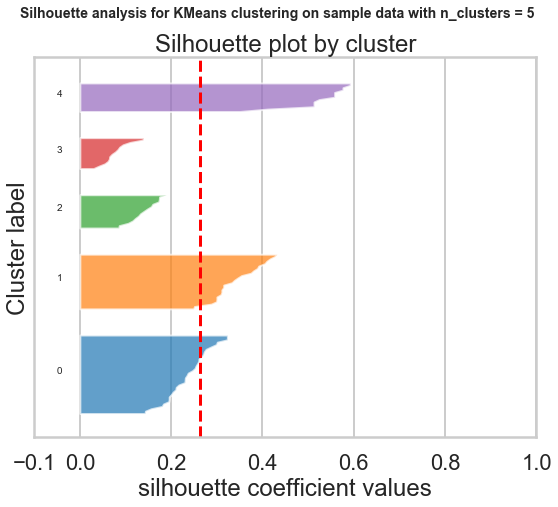

For n_clusters = 6 The average silhouette_score is : 0.2195051626409753


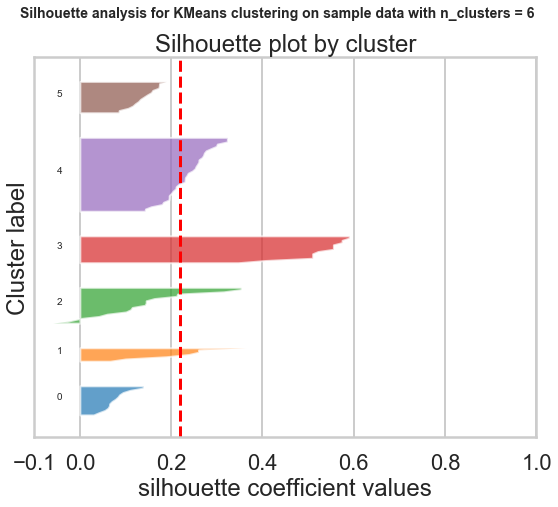

For n_clusters = 7 The average silhouette_score is : 0.24677879878927228


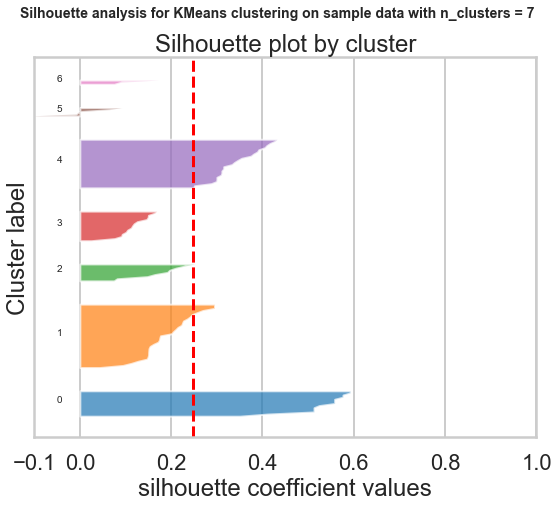

For n_clusters = 8 The average silhouette_score is : 0.21473848523111128


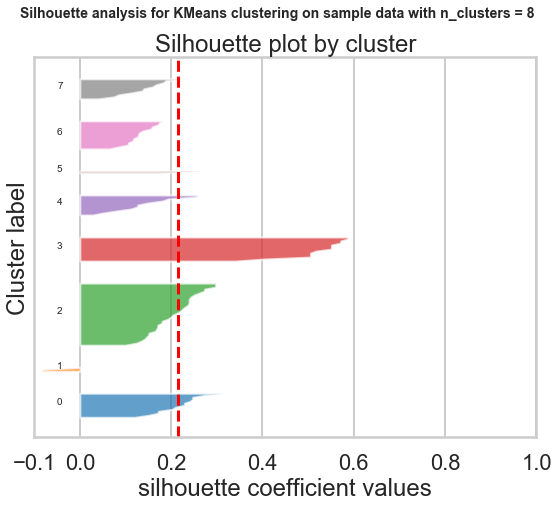

For n_clusters = 9 The average silhouette_score is : 0.1885976954579997


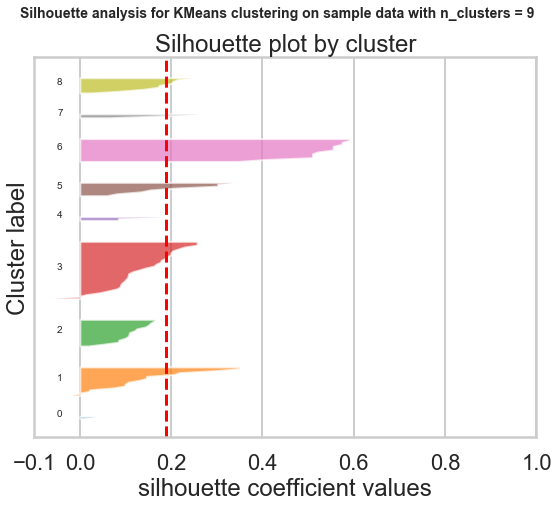

For n_clusters = 10 The average silhouette_score is : 0.16453776617905372


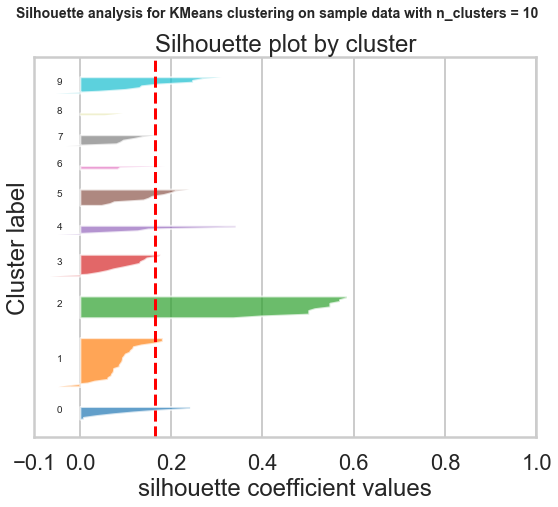

In [57]:
range_n_clusters = range(2,11)
silhouette_scores=[]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 7)

    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot by cluster")
    ax1.set_xlabel("silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


Text(0, 0.5, 'Silhoutte Score')

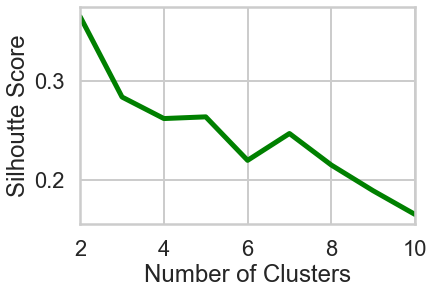

In [59]:
plt.plot(range(2,11),silhouette_scores,color='green',linewidth=5)
plt.xlim(2,10)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

Below we plot each of the points onto a 2-D plot, with components given by PCA. The clusters are then colored for $k$ ranging from 2 through 7. Inspection of these plots suggests that any solution from $k$ = 2 through 6 would be acceptable.
However, the choice of a two-dimensional model is somewhat arbitrary and could limit our interpretation and so I checked the best number of dimensions in a new PCA call (see next section).

In [62]:
# Running PCA and saving the labels
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure,show

# First, put labels for each of the different models (3-5 will be of interest)
df_pivot['cluster2labels']=KMeans(n_clusters=2).fit_predict(x_cols)
df_pivot['cluster3labels']=KMeans(n_clusters=3).fit_predict(x_cols)
df_pivot['cluster4labels']=KMeans(n_clusters=4).fit_predict(x_cols)
df_pivot['cluster5labels']=KMeans(n_clusters=5).fit_predict(x_cols)
df_pivot['cluster6labels']=KMeans(n_clusters=6).fit_predict(x_cols)
df_pivot['cluster7labels']=KMeans(n_clusters=7).fit_predict(x_cols)

In [80]:
x_cols = np.matrix(df_pivot.iloc[:,1:33])
# Run the PCA
pca = PCA(n_components=2)
pca.fit(x_cols)
reduced=pca.transform(x_cols)
df_reduced=pd.DataFrame(reduced)

# And apply the results to 2-D space (each point is now mapped to 2D)
df_pivot['pca_x']=df_reduced.iloc[:,0]
df_pivot['pca_y']=df_reduced.iloc[:,1]

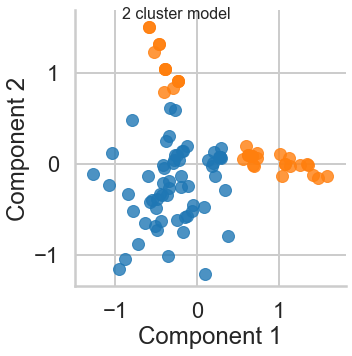

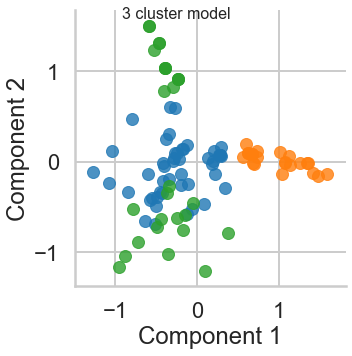

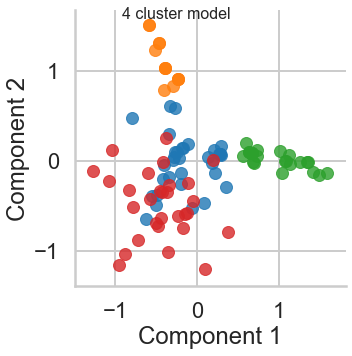

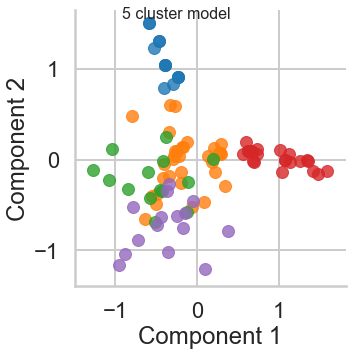

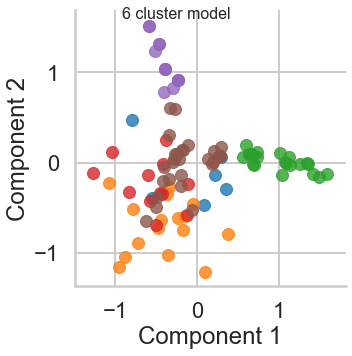

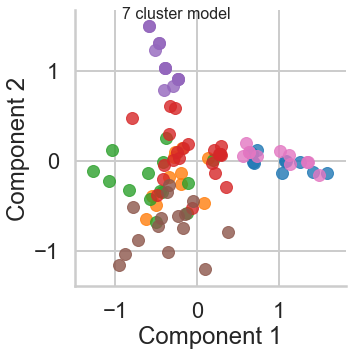

In [97]:
# Creating the plots
for i in range(2,8):
    ax = sns.lmplot(data=df_pivot, x='pca_x', y='pca_y', hue=('cluster'+str(i)+'labels'), 
                    fit_reg=False, legend=False, legend_out=True)
    _ = ax.set_axis_labels("Component 1", "Component 2")
    fig = ax.fig
    fig.suptitle(str(i)+' cluster model', fontsize=16)
    plt.show()



The PCA decomposition was run again, this time looking at multiple solutions. 
Plotting the R-squared value (below) suggests that somewhere between 4 and 6 dimensions gives the best representation of the current data.
The use of 4-6 dimensions tends to support the choice of five clusters above.

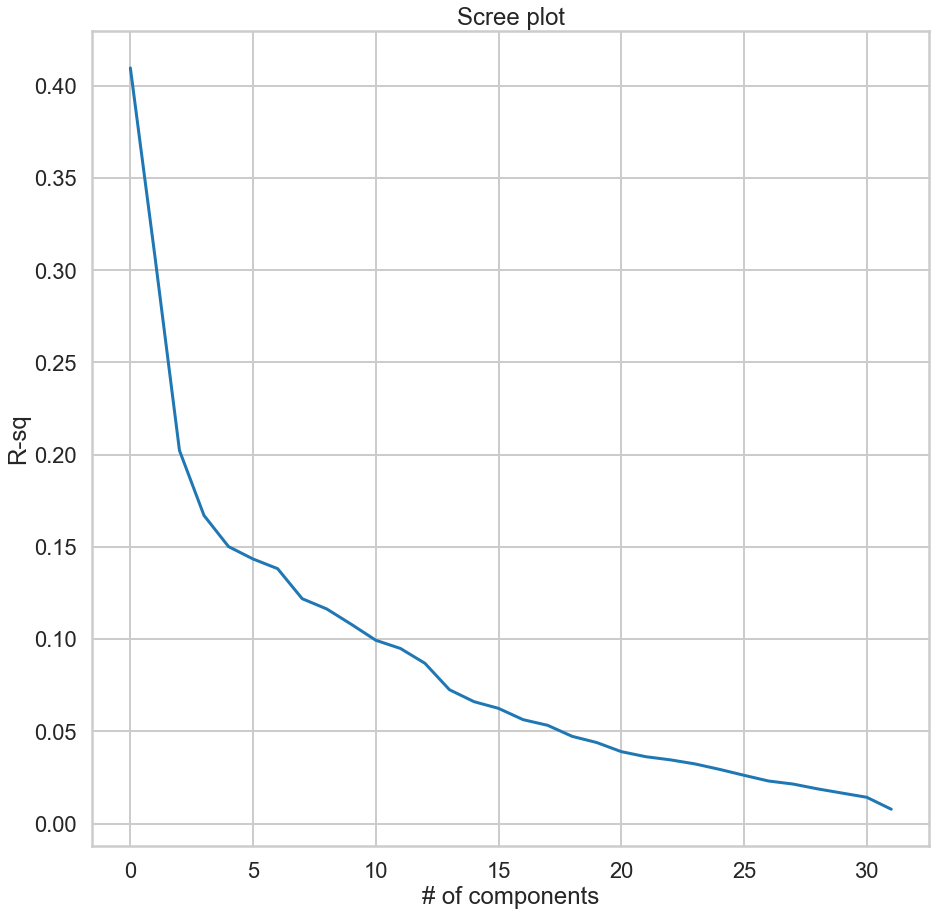

In [112]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

#dir(pca)
_ = plt.plot(pca.explained_variance_)
_ = plt.title('Scree plot')
_ = plt.xlabel('# of components')
_ = plt.ylabel('R-sq')
plt.show()

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

I ran various clustering algorithms, tuned the appropriate parameters, and then compared the best silhouette score for each algorithm.

In [121]:
# Setting up a series to record the best score for each algorithm
algorithms = ['AffinityPropagation', 'SpectralClustering', 'AgglomerativeClustering', 'DBSCAN']
algorithm_silscores = pd.Series(index=algorithms)

In [125]:
# Affinity propogation
from sklearn.cluster import AffinityPropagation

# Tuning the damping parameter (can range from .5 to 1)
dampings = [0.5, 0.6, 0.7, 0.8, 0.9]
best_score = 0.0
for damping_cand in dampings:
    ap = AffinityPropagation(damping=damping_cand)
    labels = ap.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For damping =", damping_cand,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_damping = damping_cand
        
print('Best damping parameter:', best_damping)
algorithm_silscores.loc['AffinityPropagation'] = best_score

For damping = 0.5 The average silhouette_score is : 0.12346523604478911
For damping = 0.6 The average silhouette_score is : 0.12346523604478911
For damping = 0.7 The average silhouette_score is : 0.12346523604478911
For damping = 0.8 The average silhouette_score is : 0.08954554999885996
For damping = 0.9 The average silhouette_score is : 0.08954554999885996
Best damping parameter: 0.5


In [126]:
# Spectral Clustering
from sklearn.cluster import SpectralClustering

# Tuning the n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    sc = SpectralClustering(n_clusters=n_clusters)
    labels = sc.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['SpectralClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.07631909829627558
For n_clusters = 3 The average silhouette_score is : 0.10611539040197304
For n_clusters = 4 The average silhouette_score is : 0.08627893400734331
For n_clusters = 5 The average silhouette_score is : 0.09993402587297352
For n_clusters = 6 The average silhouette_score is : 0.11057030322662119
For n_clusters = 7 The average silhouette_score is : 0.08164787106585575
For n_clusters = 8 The average silhouette_score is : 0.08730111650776064
For n_clusters = 9 The average silhouette_score is : 0.0888590874014454
For n_clusters = 10 The average silhouette_score is : 0.08626172197580012
Best n_clusters parameter: 6


In [127]:
# AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering

# Tuning the n_clusters parameter. 
range_n_clusters = range(2,11)
best_score = 0.0
for n_clusters in range_n_clusters:
    ac = AgglomerativeClustering(n_clusters=n_clusters)
    labels = ac.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_n_clusters = n_clusters
        
print('Best n_clusters parameter:',best_n_clusters)
algorithm_silscores.loc['AgglomerativeClustering'] = best_score

For n_clusters = 2 The average silhouette_score is : 0.08258017823184984
For n_clusters = 3 The average silhouette_score is : 0.11625878863607858
For n_clusters = 4 The average silhouette_score is : 0.128937578158815
For n_clusters = 5 The average silhouette_score is : 0.14089739970831974
For n_clusters = 6 The average silhouette_score is : 0.1471521720461323
For n_clusters = 7 The average silhouette_score is : 0.15275152751051155
For n_clusters = 8 The average silhouette_score is : 0.15578053718604024
For n_clusters = 9 The average silhouette_score is : 0.12075124131971901
For n_clusters = 10 The average silhouette_score is : 0.09754750747147792
Best n_clusters parameter: 8


In [128]:
#DBSCAN
from sklearn.cluster import DBSCAN

# Tuning the min_samples parameter. 
range_min_samples = [1, 2, 3]
best_score = 0.0
for min_samples in range_min_samples:
    db = DBSCAN(min_samples=min_samples)
    labels = db.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, labels, random_state=10)
    print("For min_samples =", min_samples,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_min_samples = min_samples
        
print('Best min_samples parameter:',best_min_samples)
algorithm_silscores.loc['DBSCAN'] = best_score

For min_samples = 1 The average silhouette_score is : 0.19
For min_samples = 2 The average silhouette_score is : -0.021678059481408066
For min_samples = 3 The average silhouette_score is : -0.10663555825496372
Best min_samples parameter: 1


In [129]:
# Comparison of all models

print(algorithm_silscores)

AffinityPropagation        0.123465
SpectralClustering         0.110570
AgglomerativeClustering    0.155781
DBSCAN                     0.190000
dtype: float64


Of the new algorithms we tried, the DBSCAN algorithm performed best (avg. silhouette score was 0.19). That said, none of these algorithms performed well, and the standard $K$-means clustering did slightly better than any of these ($K$ = 5 had $s$-score of 0.26).

Overall, the conclusion to be reached from this dataset is that there is a lack of structure that no clustering method will solve. I would advise collecting more data. The samples:features ratio is too low, only 100 samples with 32 features. It may be that more data will not solve this problem, but we won't know that until we try.
Looking at the shape in the five-cluster plot, it might be that there is a center of customers that then becomes slowly differentiated over time.